In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
from torch.utils import tensorboard

In [13]:
series = np.array([ 45.,  46.,  53.,  51.,  56.,  45.,  79.,  63.,  54.,  54.,  54.,
        48.,  72.,  55.,  70.,  64.,  47.,  53.,  94.,  71.,  67.,  53.,
        74.,  88.,  58.,  52.,  49.,  42.,  65., 106.,  62.,  72.,  75.,
        89.,  70.,  84.,  51.,  57.,  76., 101.,  66.,  83.,  73.,  84.,
       118., 141.,  99.,  91., 104.,  97.,  97.,  74.])

In [14]:
actual = [100., 102., 103.,59.]

In [15]:
training_set = np.array(series)
training_set = np.expand_dims(training_set, axis=1)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)


def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)


num_epochs = 1500
learning_rate = 0.01

input_size = 1
hidden_size = 100
num_layers = 1

num_classes = 1
seq_length = 8

torch.manual_seed(0)

tb = tensorboard.SummaryWriter()


class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out


def train(training_data):
    x, y = sliding_windows(training_data, seq_length)

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    best_valid_loss = 2

    lstm = LSTM(input_size, hidden_size, num_classes, num_layers)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    tb.add_graph(lstm, dataX)

    lstm.train()

    # Train the model
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = lstm(dataX)
        loss = criterion(outputs, dataY)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch ", epoch)
            print("Loss ", loss.item())

            if loss.item() < best_valid_loss:
                best_valid_loss = loss.item()
                print("Weight saves!")
                torch.save(lstm.state_dict(), 'weight.pth')


train(training_data)


Epoch  0
Loss  0.13642609119415283
Weight saves!
Epoch  100
Loss  0.02951417677104473
Weight saves!
Epoch  200
Loss  0.004777232185006142
Weight saves!
Epoch  300
Loss  0.00015471180086024106
Weight saves!
Epoch  400
Loss  4.669397526413377e-07
Weight saves!
Epoch  500
Loss  2.70301939053752e-07
Weight saves!
Epoch  600
Loss  1.9387279337479413e-08
Weight saves!
Epoch  700
Loss  1.0995276412441302e-13
Weight saves!
Epoch  800
Loss  4.394372444949113e-05
Epoch  900
Loss  8.63308802223628e-09
Epoch  1000
Loss  3.8514140878256886e-13
Epoch  1100
Loss  2.058833992180098e-09
Epoch  1200
Loss  2.5289580207754625e-08
Epoch  1300
Loss  5.432653285564193e-11
Epoch  1400
Loss  3.1560108482153737e-07


In [16]:
model = LSTM(input_size, hidden_size, num_classes, num_layers)
model.load_state_dict(torch.load('weight.pth'))
model.eval()

with torch.no_grad():
    n_days = 5
    res = []
    data = training_data.tolist()

    for i in range(1, n_days):
        test = torch.Tensor(np.array(data[-seq_length:]))

        predict = model(test.unsqueeze(0)).data.numpy()
        res.append(predict.item())

        data.append(predict.tolist()[0])

result = np.array(res)
final = sc.inverse_transform(np.expand_dims(result, axis=1))
output = np.squeeze(final, axis=1).tolist()

print(output)

[60.585775941610336, 51.59383477270603, 45.889747224748135, 33.68960740417242]


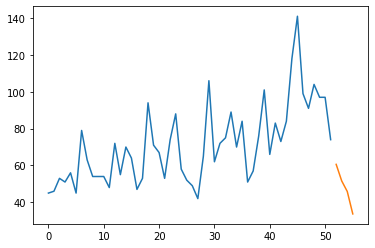

In [17]:
plt.plot(series)
plt.plot(np.arange(len(series), len(series) + 4), output)
plt.show()

In [20]:
result_df = pd.DataFrame({'Actual':actual,'Prediction':output})

In [21]:
result_df['difference'] = round(result_df['Actual'] - result_df['Prediction'], 2)
result_df['error-percentage'] = (result_df['difference'] / result_df['Actual']) * 100
result_df['error-percentage'] = result_df['error-percentage'].apply(lambda x: round(x, 2))

In [22]:
result_df

,Actual,Prediction,difference,error-percentage
0,100.0,60.585776,39.41,39.41
1,102.0,51.593835,50.41,49.42
2,103.0,45.889747,57.11,55.45
3,59.0,33.689607,25.31,42.90
